# Computational Physics 2 - Project 2

## Numerical integration of the 1D diffusion equation

The diffusion equation is of fundamental importance in physics and serves as a continuum
version of random walks. A particular class of problems, widely relevant to biology, population dynamics and evolutionary theory, are first-passage problems.
The diffusion equation is a partial differential equation because the solutions depend both on space and time. To numerically integrate the diffusion equation, both
space and time must be discretized. A common and straightforward way of discretization is the so-called finite difference scheme, by which derivatives are simply approximated as
finite differences. There are several ways in which this could be done:
  1)Explicit Euler Method
  2)Crank-Nicolson Scheme



Here, we will be implementing the Crank-Nicolson method to simulate 1D diffusion.

In [35]:
# Importing some useful libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded 

### Setting up the computation. (30 pts)

• Define the spatial domain size, $n_x$, to be sufficiently large, say, 1000 elements. Define
the collision time $∆t$, mean free path $l = ∆x$, and the diffusion coefficient $D$. From
these, define the coefficient $r ≡ D∆t/∆x^{2}$. While the value of $r$, which could be called
”Diffusion number,” does not impact on numerical stability, it can affect numerical
accuracy. A good ballpark is $r ≈ 1$. Define a position vector, where $x_i = i∆x$,
$i ∈ {0, n_x −1}$. Also, define two arrays $P_{curr}$ and $P_{next}$ of length $n_x$ to store the density
$P(x, t)$ at the current and the subsequent timestep, respectively. Define boundary
conditions (needed for the array $B$), at $x = 0$ and $x = (n_x − 1)∆x$ (first and last
elements of $P(x, t)$), such that $P(0, t) = P((n_x − 1)∆x, t) = 0$.

In [36]:
"""
Defining the parameters required
"""
nx = 1000 # spatial domain size
nt = 5000 # time domain size
L = dx = 1*10**-8 # size of spatial grid
dt = 5*10**-11 # collision time (time step)
D = 0.000002 # diffusion coefficient
r = (D*dt)/(dx**2) # diffusion number 
print(f'The value of r is : {r}')

# defining the position vector xi
Px = np.array([i*dx for i in range(nx)])

# defing arrays Pcurr and Pnext
Pcurr = np.zeros(nx)
Pnext = np.zeros(nx)

# defining boundary conditions
B = np.zeros(nx)

The value of r is : 0.9999999999999998


• Define the banded matrix $A$ as a 3 × $n_x$-element array (three rows and $n_x$ columns).
Using the Crank-Nicolson scheme, discussed in class, populate the matrix $A$. This
matrix will consist of the diagonal, as well as one upper and one lower diagonal (beware
of Python’s convention on defining the three rows of the banded matrix). Note that
defining $A$ needs to be done only once, given that $r$ is taken to be a constant. Set up
a routine that evaluates the vector $B$, which depends on $P(x, t)$ at the current time $t$.

In [37]:
# defining the banded matrix A 
A = np.zeros((3,nx))

# implementing the implicit Crank-Nicolson Scheme to populate A
"""
T is a 1000 by 1000 matrix with its diagonal, lower diagonal
and upper diagonal filled in accordingly. In the next step,
these diagonals are then extracted and these are then the
new rows of A.
"""
T = np.diagflat([-r for i in range(nx-1)], -1) +\
    np.diagflat([1.]+[2.+2.*r for i in range(nx-2)]+[1.]) +\
    np.diagflat([-r for i in range(nx-1)], 1)
A[0,1:] = np.diag(T, k=1)
A[1,:] = np.diag(T)
A[2,:nx-1] = np.diag(T, k=-1)
# print(A)
# print(A.size)

"""
Now, we set up a routine to compute the vector B
"""
def get_vector_B(B,Pcurr):
    for i in range(1,nx-1):
        B[i] = r*Pcurr[i-1] + (1-r)*2*Pcurr[i] + r*Pcurr[i+1]  
    return B

• Finally, solve the implicit matrix equation $AP = B$ using scipy’s $solve\_banded$ routine, thus obtaining the vector $P_{next}$ from $P_{curr}$.

In [38]:
Pnext = solve_banded((1,1),A,B)

Now that we have finished setting up the computation, we can move on to the project tasks.

### Project Tasks

1. Set the density to be a numerical ”Dirac Delta” in the center of your spatial domain: i.e. $P(x_{i},0)$ = 1 if $x_{i}/\Delta x = n_{x}/2$ and 0 otherwise.
Note that $P(x,0)$ is normalized in units of system size, that is, $P_{tot} ≡ \sum_{i=0}^{n_{x}-1}P(x_{i},0) = 1$.
Plot $P(x,0)$. (10 pts)


The sum is : 1.0


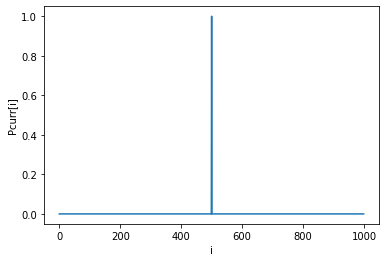

In [39]:
"""
Using  a for loop to place the dirac delta
at the very center according to the equation
"""
for i in range(nx):
    if (i/1) == (nx/2):
        Pcurr[i] = 1
    else:
        Pcurr[i] = 0

"""
Check for normalization.
Since the sum is exactly 1.0, we can say that Pcurr
is normalized!
"""
print(f'The sum is : {np.sum(Pcurr)}')

"""
Here, we plot the value of the probability against the
value at which that specific value of probability is
attained at.
"""
idx = np.arange(nx)
plt.plot(idx,Pcurr)
plt.xlabel('i')
plt.ylabel('Pcurr[i]')
plt.show()

As expected, our plot represents a "Dirac Delta" at the middle of the distribution.

2. Using your solver, obtain the subsequent density $P_{next}$, check and store the normalization and store the mean $⟨x⟩$ and variance $⟨x^{2}⟩ − ⟨x⟩^2$ of $P_{next}$. By overwriting
$P_{curr} = P_{next}$, repeat the updating a large number of times $n_t$, e.g. $n_t ≳ O(10^{4})$. Finally, plot the statistical quantities as function of time. Also plot $P(x, t)$ for various values of t on the same graph. Is the total density constant? If it is changing, comment on this. Describe the mean and variance and compare them with theory. (25 pts)


Sum of initial Pnext : 1.0000000000000002


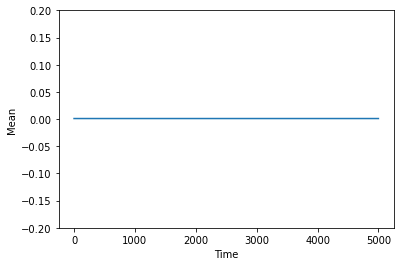

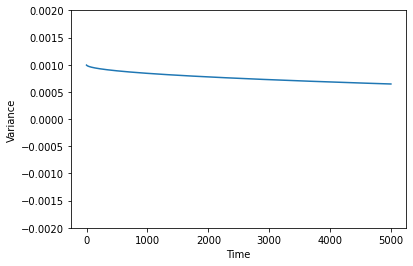

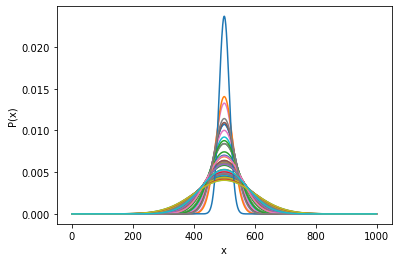

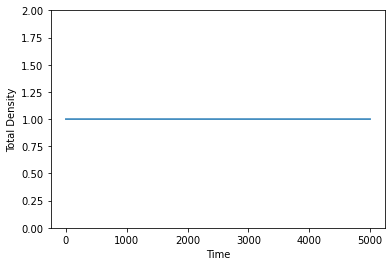

In [40]:
# initializing arrays for mean and variance
# and a variable to check whether the total density is constant
mean = np.zeros(nt)
var = np.zeros(nt)
total_density = np.zeros(nt)

"""
First, we compute our new B using the Pcurr
that we initialized in the previous step.
Next, we obtain the subsequent density Pnext.
Next, the sum of Pcrr is evaluated. Since the sum is
very close to 1, Pnext is normalized. 
"""
B = get_vector_B(B,Pcurr)
Pnext = solve_banded((1,1),A,B)
print(f'Sum of initial Pnext : {np.sum(Pnext)}')
# storing normalization
normalization = np.sum(Pnext)
# storing the mean and variance of the initial Pnext
mean[0] = np.mean(Pnext)
var[0] = np.var(Pnext)

"""
Here, we generate some random time points to get the
densities at. This rand array contains 500 random
integers from 0 to 5000.
Next, a new matrix densities is initialized to store
the densities at these 500 points in time
"""
points = 50
rand = np.random.randint(5000, size=(points))
densities = np.zeros((points,nx))

"""
This is our main for loop. 
This loop constantly overwrites Pcurr = Pnext,
and does the previous steps for nt times (nt = 5000)
The means and variances are stored and plotted as a 
function of time. K, the value for normalization
is also updated at each iteration.
"""
for i in range(0,nt):

    Pcurr = Pnext
    B = get_vector_B(B,Pcurr)
    Pnext = solve_banded((1,1),A,B)

    # to plot densities at random timesteps
    for j in range(points):
        if i == rand[j]:
            densities[j,0:] = Pnext

    total_density[i] =  np.sum(Pnext)
    mean[i] = np.mean(Pnext)

    # calculating the variance 
    var[i] = np.var(Pnext/np.linalg.norm(Pnext))


# defining an index to plot against time
time = np.arange(nt)

# plot for mean
plt.plot(time, mean)
plt.xlabel('Time')
plt.ylabel('Mean')
plt.ylim([-0.2, 0.2])
plt.show()

# plot for variance
plt.plot(time, var)
plt.xlabel('Time')
plt.ylabel('Variance')
plt.ylim([-0.002, 0.002])
plt.show()

# plot for the densities
for i in range(points):
    plt.plot(idx,densities[i,0:])
plt.xlabel('x')
plt.ylabel('P(x)')
plt.show()

# plot for total density at each timestep
plt.plot(time, total_density)
plt.xlabel('Time')
plt.ylabel('Total Density')
plt.ylim([0, 2])
plt.show()

As seen from the plot with densities at different timesteps, here, we can see the density 'spread' over  the distribution. This is as expected. As can also be seen, the total density is almost a constant. There is a very slight increase, but this is neglegible due to our scale of magnitude being much higher. However, this could be a problem when we plot for much larger times since the change is almost linear.
As expected, the mean is zero at all timesteps. However, the variance shows a slight decrease as expected, even though we normalized our array before calculation. If this wasn't done, it would increase linearly with time!
The axis limits can be changed and the time decreased to see the change more clearly.

3. Now shift your initial condition (Eq. 1) such that the ”Dirac Delta” is located near one of the boundaries, say at $x_i / ∆x = 10$. Repeat the computation from before. Besides
the previous values, also plot the change in density, $∆P_{tot} ≡ P_{tot,curr} − P_{tot,next}$ as a function of time. Interpret your findings in terms of the Smirnov density. (25 pts)

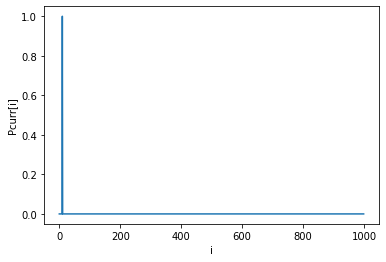

Sum of initial Pnext : 1.000010424213363


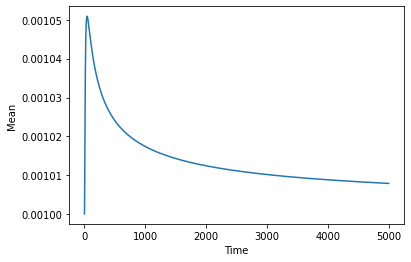

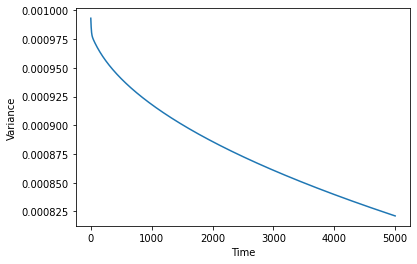

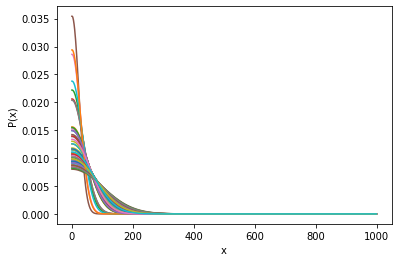

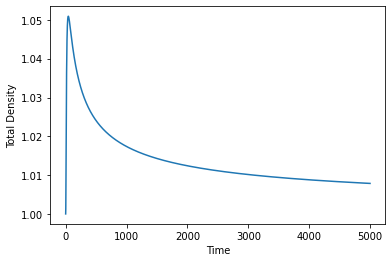

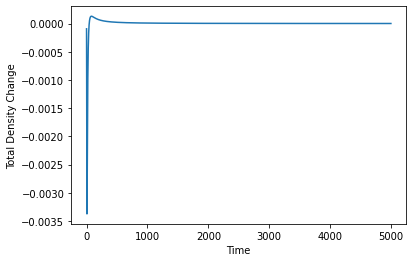

In [41]:
Pcurr = np.zeros(nx)

"""
Using a for loop to place the dirac delta
near one of the boundaries
"""
for i in range(nx):
    if (i/1) == 10:
        Pcurr[i] = 1
    else:
        Pcurr[i] = 0


"""
Here, we plot the value of the probability against the
value at which that specific value of probability is
attained at.
"""
idx = np.arange(nx)
plt.plot(idx,Pcurr)
plt.xlabel('i')
plt.ylabel('Pcurr[i]')
plt.show()


# initializing arrays for mean and variance
# and a variable to check whether the total density is constant
mean = np.zeros(nt)
var = np.zeros(nt)
total_density = np.zeros(nt)
density_change = np.zeros(nt)

"""
First, we compute our new B using the Pcurr
that we initialized in the previous step.
Next, we obtain the subsequent density Pnext.
Next, the sum of Pcrr is evaluated. Since the sum is
very close to 1, Pnext is normalized. 
"""
B = get_vector_B(B,Pcurr)
Pnext = solve_banded((1,1),A,B)
print(f'Sum of initial Pnext : {np.sum(Pnext)}')
# storing normalization
normalization = np.sum(Pnext)
# storing the mean and variance of the initial Pnext
mean[0] = np.mean(Pnext)
var[0] = np.var(Pnext)

"""
Here, we generate some random time points to get the
densities at. This rand array contains 500 random
integers from 0 to 5000.
Next, a new matrix densities is initialized to store
the densities at these 500 points in time
"""
points = 50
rand = np.random.randint(5000, size=(points))
densities = np.zeros((points,nx))

"""
This is our main for loop. 
This loop constantly overwrites Pcurr = Pnext,
and does the previous steps for nt times (nt = 5000)
The means and variances are stored and plotted as a 
function of time. K, the value for normalization
is also updated at each iteration.
"""
for i in range(0,nt):
    Pcurr = Pnext
    temp1 = np.sum(Pcurr)
    B = get_vector_B(B,Pcurr)
    Pnext = solve_banded((1,1),A,B)
    temp2 = np.sum(Pnext)

    # to plot densities at random timesteps
    for j in range(points):
        if i == rand[j]:
            densities[j,0:] = Pnext

    total_density[i] =  np.sum(Pnext)
    density_change[i] = temp1 - temp2
    mean[i] = np.mean(Pnext)

    # calculating the variance 
    var[i] = np.var(Pnext/np.linalg.norm(Pnext))


# defining an index to plot against time
time = np.arange(nt)

# plot for mean
plt.plot(time, mean)
plt.xlabel('Time')
plt.ylabel('Mean')
#plt.ylim([-0.2, 0.2])
plt.show()

# plot for variance
plt.plot(time, var)
plt.xlabel('Time')
plt.ylabel('Variance')
#plt.ylim([-0.002, 0.002])
plt.show()

# plot for the densities
for i in range(points):
    plt.plot(idx,densities[i,0:])
plt.xlabel('x')
plt.ylabel('P(x)')
plt.show()

# plot for total density at each timestep
plt.plot(time, total_density)
plt.xlabel('Time')
plt.ylabel('Total Density')
#plt.ylim([0, 2])
plt.show()

# plot for the change in total density at each step
plt.plot(time, density_change)
plt.xlabel('Time')
plt.ylabel('Total Density Change')
#plt.ylim([-1, 1])
plt.show()

Here, as instructed, the initial conditions were similar but with the delta at 10 steps from the left boundary. As expected, there some significant differences since the distributuon had a stronger interaction with the boundary. For a closer look, I have plotted for a time of 50s below:

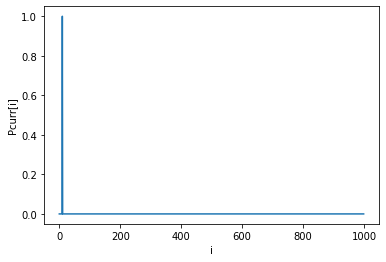

Sum of initial Pnext : 1.000010424213363


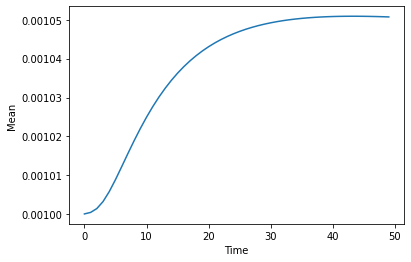

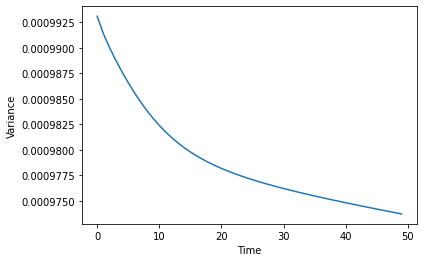

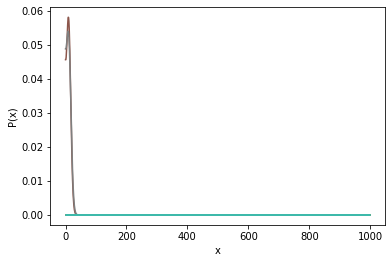

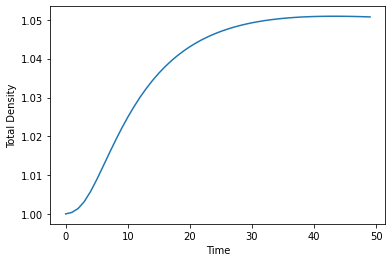

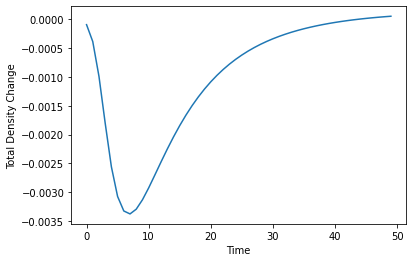

In [42]:
Pcurr = np.zeros(nx)
nt = 50

"""
Using a for loop to place the dirac delta
near one of the boundaries
"""
for i in range(nx):
    if (i/1) == 10:
        Pcurr[i] = 1
    else:
        Pcurr[i] = 0


"""
Here, we plot the value of the probability against the
value at which that specific value of probability is
attained at.
"""
idx = np.arange(nx)
plt.plot(idx,Pcurr)
plt.xlabel('i')
plt.ylabel('Pcurr[i]')
plt.show()


# initializing arrays for mean and variance
# and a variable to check whether the total density is constant
mean = np.zeros(nt)
var = np.zeros(nt)
total_density = np.zeros(nt)
density_change = np.zeros(nt)

"""
First, we compute our new B using the Pcurr
that we initialized in the previous step.
Next, we obtain the subsequent density Pnext.
Next, the sum of Pcrr is evaluated. Since the sum is
very close to 1, Pnext is normalized. 
"""
B = get_vector_B(B,Pcurr)
Pnext = solve_banded((1,1),A,B)
print(f'Sum of initial Pnext : {np.sum(Pnext)}')
# storing normalization
normalization = np.sum(Pnext)
# storing the mean and variance of the initial Pnext
mean[0] = np.mean(Pnext)
var[0] = np.var(Pnext)

"""
Here, we generate some random time points to get the
densities at. This rand array contains 500 random
integers from 0 to 5000.
Next, a new matrix densities is initialized to store
the densities at these 500 points in time
"""
points = 50
rand = np.random.randint(5000, size=(points))
densities = np.zeros((points,nx))

"""
This is our main for loop. 
This loop constantly overwrites Pcurr = Pnext,
and does the previous steps for nt times (nt = 5000)
The means and variances are stored and plotted as a 
function of time. K, the value for normalization
is also updated at each iteration.
"""
for i in range(0,nt):
    Pcurr = Pnext
    temp1 = np.sum(Pcurr)
    B = get_vector_B(B,Pcurr)
    Pnext = solve_banded((1,1),A,B)
    temp2 = np.sum(Pnext)

    # to plot densities at random timesteps
    for j in range(points):
        if i == rand[j]:
            densities[j,0:] = Pnext

    total_density[i] =  np.sum(Pnext)
    density_change[i] = temp1 - temp2
    mean[i] = np.mean(Pnext)

    # calculating the variance 
    var[i] = np.var(Pnext/np.linalg.norm(Pnext))


# defining an index to plot against time
time = np.arange(nt)

# plot for mean
plt.plot(time, mean)
plt.xlabel('Time')
plt.ylabel('Mean')
#plt.ylim([-0.2, 0.2])
plt.show()

# plot for variance
plt.plot(time, var)
plt.xlabel('Time')
plt.ylabel('Variance')
#plt.ylim([-0.002, 0.002])
plt.show()

# plot for the densities
for i in range(points):
    plt.plot(idx,densities[i,0:])
plt.xlabel('x')
plt.ylabel('P(x)')
plt.show()

# plot for total density at each timestep
plt.plot(time, total_density)
plt.xlabel('Time')
plt.ylabel('Total Density')
#plt.ylim([0, 2])
plt.show()

# plot for the change in total density at each step
plt.plot(time, density_change)
plt.xlabel('Time')
plt.ylabel('Total Density Change')
#plt.ylim([-1, 1])
plt.show()

As seen, the total density and the mean increases non-linearly and the variance decreases non-linearly. These shifts can be explained in terms of the Smirnov Density, which means that the distribution will have a higher value in the right side where the original delta was.

4. By increasing and decreasing the value of r by an order of magnitude, discuss the numerical accuracy of your results. Note: When comparing to exact results, remember
that a change to r means a change to at least one of the three parameters involved. (10 pts)

### For r = 0.1:

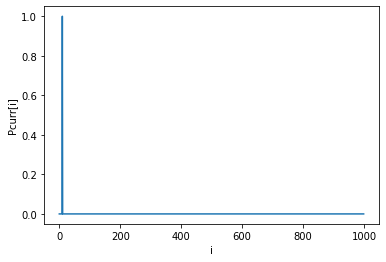

Sum of initial Pnext : 1.0000057333173495


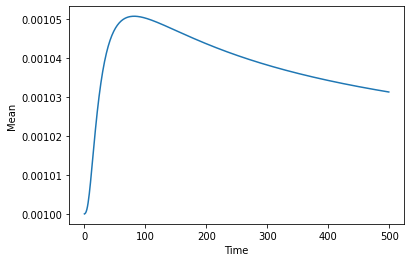

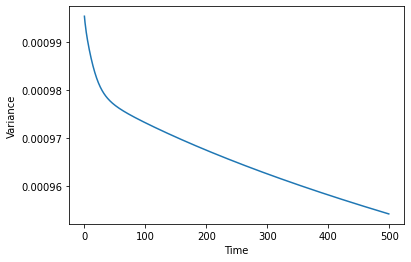

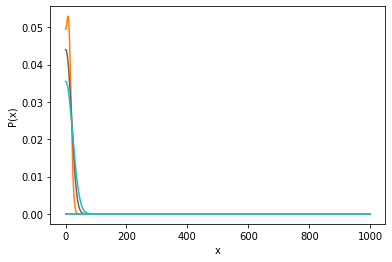

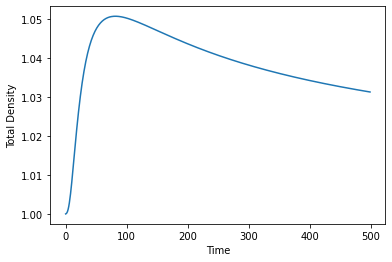

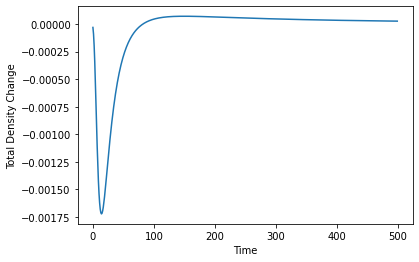

In [43]:
Pcurr = np.zeros(nx)
nt = 500
r = 0.1

"""
Using a for loop to place the dirac delta
near one of the boundaries
"""
for i in range(nx):
    if (i/1) == 10:
        Pcurr[i] = 1
    else:
        Pcurr[i] = 0


"""
Here, we plot the value of the probability against the
value at which that specific value of probability is
attained at.
"""
idx = np.arange(nx)
plt.plot(idx,Pcurr)
plt.xlabel('i')
plt.ylabel('Pcurr[i]')
plt.show()


# initializing arrays for mean and variance
# and a variable to check whether the total density is constant
mean = np.zeros(nt)
var = np.zeros(nt)
total_density = np.zeros(nt)
density_change = np.zeros(nt)

"""
First, we compute our new B using the Pcurr
that we initialized in the previous step.
Next, we obtain the subsequent density Pnext.
Next, the sum of Pcrr is evaluated. Since the sum is
very close to 1, Pnext is normalized. 
"""
B = get_vector_B(B,Pcurr)
Pnext = solve_banded((1,1),A,B)
print(f'Sum of initial Pnext : {np.sum(Pnext)}')
# storing normalization
normalization = np.sum(Pnext)
# storing the mean and variance of the initial Pnext
mean[0] = np.mean(Pnext)
var[0] = np.var(Pnext)

"""
Here, we generate some random time points to get the
densities at. This rand array contains 500 random
integers from 0 to 5000.
Next, a new matrix densities is initialized to store
the densities at these 500 points in time
"""
points = 50
rand = np.random.randint(5000, size=(points))
densities = np.zeros((points,nx))

"""
This is our main for loop. 
This loop constantly overwrites Pcurr = Pnext,
and does the previous steps for nt times (nt = 5000)
The means and variances are stored and plotted as a 
function of time. K, the value for normalization
is also updated at each iteration.
"""
for i in range(0,nt):
    Pcurr = Pnext
    temp1 = np.sum(Pcurr)
    B = get_vector_B(B,Pcurr)
    Pnext = solve_banded((1,1),A,B)
    temp2 = np.sum(Pnext)

    # to plot densities at random timesteps
    for j in range(points):
        if i == rand[j]:
            densities[j,0:] = Pnext

    total_density[i] =  np.sum(Pnext)
    density_change[i] = temp1 - temp2
    mean[i] = np.mean(Pnext)

    # calculating the variance 
    var[i] = np.var(Pnext/np.linalg.norm(Pnext))


# defining an index to plot against time
time = np.arange(nt)

# plot for mean
plt.plot(time, mean)
plt.xlabel('Time')
plt.ylabel('Mean')
#plt.ylim([-0.2, 0.2])
plt.show()

# plot for variance
plt.plot(time, var)
plt.xlabel('Time')
plt.ylabel('Variance')
#plt.ylim([-0.002, 0.002])
plt.show()

# plot for the densities
for i in range(points):
    plt.plot(idx,densities[i,0:])
plt.xlabel('x')
plt.ylabel('P(x)')
plt.show()

# plot for total density at each timestep
plt.plot(time, total_density)
plt.xlabel('Time')
plt.ylabel('Total Density')
#plt.ylim([0, 2])
plt.show()

# plot for the change in total density at each step
plt.plot(time, density_change)
plt.xlabel('Time')
plt.ylabel('Total Density Change')
#plt.ylim([-1, 1])
plt.show()

### For r = 10:

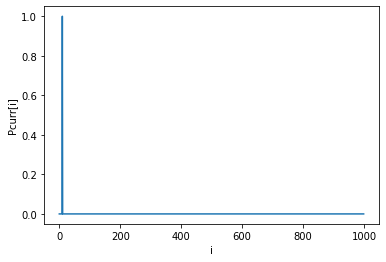

Sum of initial Pnext : 1.000057333173495


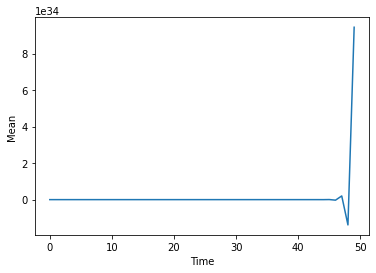

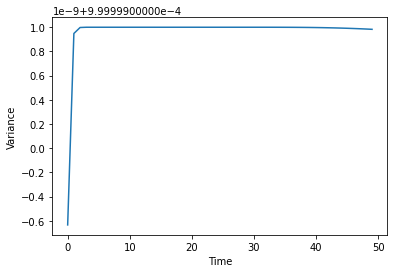

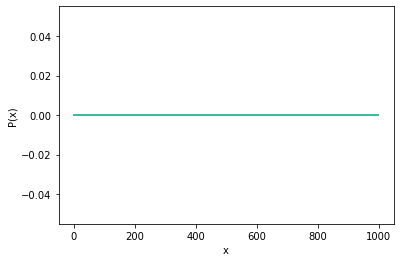

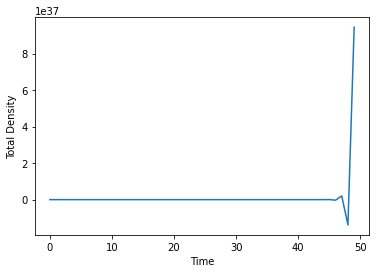

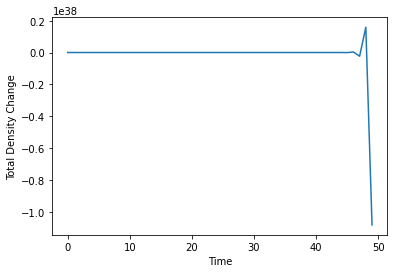

In [44]:
Pcurr = np.zeros(nx)
nt = 50
r = 10

"""
Using a for loop to place the dirac delta
near one of the boundaries
"""
for i in range(nx):
    if (i/1) == 10:
        Pcurr[i] = 1
    else:
        Pcurr[i] = 0


"""
Here, we plot the value of the probability against the
value at which that specific value of probability is
attained at.
"""
idx = np.arange(nx)
plt.plot(idx,Pcurr)
plt.xlabel('i')
plt.ylabel('Pcurr[i]')
plt.show()


# initializing arrays for mean and variance
# and a variable to check whether the total density is constant
mean = np.zeros(nt)
var = np.zeros(nt)
total_density = np.zeros(nt)
density_change = np.zeros(nt)

"""
First, we compute our new B using the Pcurr
that we initialized in the previous step.
Next, we obtain the subsequent density Pnext.
Next, the sum of Pcrr is evaluated. Since the sum is
very close to 1, Pnext is normalized. 
"""
B = get_vector_B(B,Pcurr)
Pnext = solve_banded((1,1),A,B)
print(f'Sum of initial Pnext : {np.sum(Pnext)}')
# storing normalization
normalization = np.sum(Pnext)
# storing the mean and variance of the initial Pnext
mean[0] = np.mean(Pnext)
var[0] = np.var(Pnext)

"""
Here, we generate some random time points to get the
densities at. This rand array contains 500 random
integers from 0 to 5000.
Next, a new matrix densities is initialized to store
the densities at these 500 points in time
"""
points = 50
rand = np.random.randint(5000, size=(points))
densities = np.zeros((points,nx))

"""
This is our main for loop. 
This loop constantly overwrites Pcurr = Pnext,
and does the previous steps for nt times (nt = 5000)
The means and variances are stored and plotted as a 
function of time. K, the value for normalization
is also updated at each iteration.
"""
for i in range(0,nt):
    Pcurr = Pnext
    temp1 = np.sum(Pcurr)
    B = get_vector_B(B,Pcurr)
    Pnext = solve_banded((1,1),A,B)
    temp2 = np.sum(Pnext)

    # to plot densities at random timesteps
    for j in range(points):
        if i == rand[j]:
            densities[j,0:] = Pnext

    total_density[i] =  np.sum(Pnext)
    density_change[i] = temp1 - temp2
    mean[i] = np.mean(Pnext)

    # calculating the variance 
    var[i] = np.var(Pnext/np.linalg.norm(Pnext))


# defining an index to plot against time
time = np.arange(nt)

# plot for mean
plt.plot(time, mean)
plt.xlabel('Time')
plt.ylabel('Mean')
#plt.ylim([-0.2, 0.2])
plt.show()

# plot for variance
plt.plot(time, var)
plt.xlabel('Time')
plt.ylabel('Variance')
#plt.ylim([-0.002, 0.002])
plt.show()

# plot for the densities
for i in range(points):
    plt.plot(idx,densities[i,0:])
plt.xlabel('x')
plt.ylabel('P(x)')
plt.show()

# plot for total density at each timestep
plt.plot(time, total_density)
plt.xlabel('Time')
plt.ylabel('Total Density')
#plt.ylim([0, 2])
plt.show()

# plot for the change in total density at each step
plt.plot(time, density_change)
plt.xlabel('Time')
plt.ylabel('Total Density Change')
#plt.ylim([-1, 1])
plt.show()

Here, we manually increased our value of r by the corresponding order of magnitude. This is equivalent to changing the diffusion coefficient D by an order of magnitude. The other parameters weren't changed in order to keep our results fair. As seen, alomost all the plots show some change due to this. Since the total density starts to increase at an alarming rate, there is some numerical inaccuracy here (relative to the orders of magnitude)! However, for the smaller value of r, the results were similar to when r was approximately 1. 
In conclusion, this proves what we learnt in theory, that exceeding r = 1 results in some inaccuracies.